In [40]:
import warnings
import calendar

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from business_models import greenplum
from business_models.greenplum import GreenplumManager
from business_models import hahn

https://wiki.yandex-team.ru/users/ghostrider/cargo-x-efficiency/.edit?force-data-ui=true

# Hourly Scale

In [2]:
fct_supply_state_hist_sql = '''
    with t as (
        select gs::timestamp  time_slot,
            case when extract(isodow from gs) >= 6 then 1 else 0 end is_weekend,
               to_char(gs, 'YYYY-MM') mnth
        from generate_series('2023-05-01', '2023-07-31 23:00:00', interval '1 hour') as gs)
    select
                agglomeration_geo_node_id, time_slot, is_weekend, mnth,
                park_taximeter_id || '_' || executor_profile_id dbid_uuid,
                sum(duration_sec) supply_sec,
                sum(case when executor_status_code != 'free' then duration_sec else 0 end) util_sec

    from taxi_cdm_supply.fct_supply_state_hist s
    join t on t.time_slot between s.msk_valid_from_dttm and s.msk_valid_to_dttm
    where enabled_tariff_class_code_list && '{"cargo", "cargocorp","cargo_long", "cargo_express"}'
      and agglomeration_geo_node_id in ('br_moscow', 'br_saintpetersburg', 'br_krasnodar', 'br_novosibirsk')
      and msk_valid_from_dttm::date between '2023-05-01' and '2023-07-31'
      and executor_status_code in ('free', 'waiting', 'driving', 'transporting')
    group by 1, 2, 3, 4, 5
'''

In [ ]:
supply_state = greenplum(fct_supply_state_hist_sql)

In [38]:
hourly_data_sql = '''
    with d as (
        SELECT d.claim_uuid, d.order_id, d.final_claim_status, d.source_city_name_en,
               COALESCE(utc_claim_performer_found_dttm, utc_waybill_assigned_dttm) assign,
               sum(user_wo_vat_lcy_cost) user_cost,
               sum(client_surge_bonus_lcy_cost) client_surge,
               min(d.utc_created_dttm) utc_created_dttm,
               max(client_type) client_type
        from delivery_cdm_delivery.fct_delivery d
                 left join delivery_cdm_finance.fct_delivery_metric dm on d.united_claim_sk = dm.united_claim_sk
            and d.visit_claim_seq = dm.visit_claim_seq
        where 1=1
            and d.utc_order_created_dttm::date between '2023-05-01' and '2023-07-31'
            and claim_created_tariff_class_code_list && '{"cargo", "cargocorp","cargo_long", "cargo_express"}'
            --   and d.final_claim_status != 'delivered_finish'
            and source_country_name_en = 'Russia'
            and source_city_name_en in ('Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk')
        group by 1, 2, 3, 4, 5)
    select claim_uuid, d.order_id, DATE_TRUNC('hour', utc_created_dttm) + interval '3 hour' msk_created_timeslot,
           case when final_claim_status = 'delivered_finish' then 1 else 0 end  delivered_finish,
           source_city_name_en,
           user_cost, client_surge,
           max(client_type) client_type,
           sum(case when c.utc_seen_dttm is not null then 1 end) offer_seen,
           sum(case when c.utc_assigned_dttm is not null then 1 end) offer_accepted,
           case when max(assign) is not null then 1 else 0 end assign
    from d
    left join taxi_cdm_supply.fct_order_candidate as c on c.order_id = d.order_id
    group by 1, 2, 3, 4, 5, 6, 7
'''

In [39]:
hourly_data = greenplum(hourly_data_sql)

ERROR in job  launched by /usr/lib/python3.7/runpy.py. <class 'sqlalchemy.exc.OperationalError'>: 
 Traceback (most recent call last):
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/engine/base.py", line 3366, in _wrap_pool_connect
    return fn()
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 327, in connect
    return _ConnectionFairy._checkout(self)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 894, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 498, in checkout
    rec._checkin_failed(err, _fairy_was_created=False)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/langhelpers.py", line 72, in __exit__
    with_traceback=exc_tb,
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/compat.py", line 211, in raise_
    raise e

(psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "gpdb-master.taxi.yandex.net" (2a02:6b8:c0e:a6c:0:1315:92d9:f7fc) and accepting
	TCP/IP connections on port 5432?

(Background on this error at: https://sqlalche.me/e/14/e3q8), Retrying in 3 seconds...


ERROR in job  launched by /usr/lib/python3.7/runpy.py. <class 'sqlalchemy.exc.OperationalError'>: 
 Traceback (most recent call last):
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/engine/base.py", line 3366, in _wrap_pool_connect
    return fn()
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 327, in connect
    return _ConnectionFairy._checkout(self)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 894, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 498, in checkout
    rec._checkin_failed(err, _fairy_was_created=False)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/langhelpers.py", line 72, in __exit__
    with_traceback=exc_tb,
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/compat.py", line 211, in raise_
    raise e

(psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "gpdb-master.taxi.yandex.net" (2a02:6b8:c0e:a6c:0:1315:92d9:f7fc) and accepting
	TCP/IP connections on port 5432?

(Background on this error at: https://sqlalche.me/e/14/e3q8), Retrying in 3 seconds...


ERROR in job  launched by /usr/lib/python3.7/runpy.py. <class 'sqlalchemy.exc.OperationalError'>: 
 Traceback (most recent call last):
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/engine/base.py", line 3366, in _wrap_pool_connect
    return fn()
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 327, in connect
    return _ConnectionFairy._checkout(self)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 894, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 498, in checkout
    rec._checkin_failed(err, _fairy_was_created=False)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/langhelpers.py", line 72, in __exit__
    with_traceback=exc_tb,
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/compat.py", line 211, in raise_
    raise e

(psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "gpdb-master.taxi.yandex.net" (2a02:6b8:c0e:a6c:0:1315:92d9:f7fc) and accepting
	TCP/IP connections on port 5432?

(Background on this error at: https://sqlalche.me/e/14/e3q8), Retrying in 5 seconds...


ERROR in job  launched by /usr/lib/python3.7/runpy.py. <class 'sqlalchemy.exc.OperationalError'>: 
 Traceback (most recent call last):
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/engine/base.py", line 3366, in _wrap_pool_connect
    return fn()
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 327, in connect
    return _ConnectionFairy._checkout(self)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 894, in _checkout
    fairy = _ConnectionRecord.checkout(pool)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 498, in checkout
    rec._checkin_failed(err, _fairy_was_created=False)
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/langhelpers.py", line 72, in __exit__
    with_traceback=exc_tb,
  File "/home/ghostrider/.local/lib/python3.7/site-packages/sqlalchemy/util/compat.py", line 211, in raise_
    raise e

OperationalError: (psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "gpdb-master.taxi.yandex.net" (2a02:6b8:c0e:a6c:0:1315:92d9:f7fc) and accepting
	TCP/IP connections on port 5432?

(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [9]:
# drop duplicates
hourly_data = hourly_data.groupby(['claim_uuid', 'client_type']).max().reset_index()

In [10]:
hourly_data.fillna(0, inplace=True)

hourly_data = hourly_data[hourly_data['claim_uuid']!=0]

hourly_data['is_weekend'] = hourly_data['msk_created_timeslot'].apply(
    lambda x: 1 if x.dayofweek in [5, 6] else 0)

hourly_data['mnth'] = hourly_data['msk_created_timeslot'].apply(lambda x: str(x)[:7])

hourly_data['hour'] = hourly_data.msk_created_timeslot.apply(lambda x: x.hour)

hourly_data['is_surge'] = hourly_data['client_surge'].apply(lambda x: 1 if x>0 else 0)

hourly_data = hourly_data[~hourly_data['mnth'].isin(['2023-04', '2023-08'])]

In [11]:
hourly_data

claim_uuid client_type  \
0        00001f497f80402185c9a672eeddabd8         C2C   
1        000020bc99264bb3b7fc1a8cd9fcba05         C2C   
2        00002623b0b74ae2859f69c4834881b3         B2B   
3        000027abfa2a48fc9ce36cfa20449745         C2C   
4        000027c4612a443ca64c3138f7138af2         C2C   
...                                   ...         ...   
1759302  ffffe3e165254a99999165bb5be558cb         C2C   
1759303  fffff1a8660147069d25143a6707fe3a         C2C   
1759304  fffff6299c70431f8fca6ab112937b92         C2C   
1759305  fffffb7f71434c5bb42c69ee24b6b495         C2C   
1759306  fffffcc5d72e4db8a316621614cb03d7         C2C   

                                 order_id msk_created_timeslot  \
0        490b463c2e44bddd93e7740380352a0e  2023-07-31 19:00:00   
1        aee7cfca0901bafba7b715514d0b5155  2023-06-15 11:00:00   
2        64ce577488c5c86e91a7556d2a563770  2023-05-30 07:00:00   
3        fa88fde01c9fce58890759dbd855f73b  2023-07-27 22:00:00   
4        bc3a4f181d47d6c8afa2f5ff312d2ff5  2023-07-26 16:00:00   
...                                   ...                  ...   
1759302  3dd5e0db5c938f7ab983dc7f8c3485f2  2023-07-16 15:00:00   
1759303  fa9960af0da41f09ae72f5bac0975be8  2023-07-21 09:00:00   
1759304  1be15a850cb3ed499326d841cec754c4  2023-06-18 12:00:00   
1759305  6b9903fbd97be1a0aad7fd4892c507f1  2023-05-05 12:00:00   
1759306  c515bb1caed7e099a3a5edf0263de1ec  2023-05-15 09:00:00   

         delivered_finish source_city_name_en  user_cost  client_surge  \
0                       1              Moscow     2191.0           0.0   
1                       1           Krasnodar     1023.0         240.0   
2                       1              Moscow     2228.0           0.0   
3                       1              Moscow     1121.0           0.0   
4                       1              Moscow     1905.0           0.0   
...                   ...                 ...        ...           ...   
1759302                 1    Saint-Petersburg      854.0           0.0   
1759303                 1    Saint-Petersburg     1329.0           0.0   
1759304                 1              Moscow      973.0         110.0   
1759305                 1    Saint-Petersburg     4249.0         260.0   
1759306                 1              Moscow     1535.0           0.0   

         offer_seen  offer_accepted  assign  is_weekend     mnth  hour  \
0               1.0             1.0       1           0  2023-07    19   
1               1.0             1.0       1           0  2023-06    11   
2               1.0             1.0       1           0  2023-05     7   
3               4.0             1.0       1           0  2023-07    22   
4               1.0             1.0       1           0  2023-07    16   
...             ...             ...     ...         ...      ...   ...   
1759302         1.0             1.0       1           1  2023-07    15   
1759303         1.0             1.0       1           0  2023-07     9   
1759304         1.0             1.0       1           1  2023-06    12   
1759305         4.0             1.0       1           0  2023-05    12   
1759306         1.0             1.0       1           0  2023-05     9   

         is_surge  
0               0  
1               1  
2               0  
3               0  
4               0  
...           ...  
1759302         0  
1759303         0  
1759304         1  
1759305         1  
1759306         0  

[1758837 rows x 15 columns]

In [12]:
hourly_data.claim_uuid.count() == hourly_data.claim_uuid.nunique()

True

In [73]:
ss_agg = supply_state.groupby(['agglomeration_geo_node_id', 'time_slot', 'is_weekend', 'mnth']).agg(
    executors=('dbid_uuid', 'nunique'), supply_sec=('supply_sec', 'sum'),
    util_sec=('util_sec', 'sum'),).reset_index()
ss_agg['hour'] = ss_agg.time_slot.apply(lambda x: x.hour)

In [78]:
ss_df = ss_agg.groupby(['agglomeration_geo_node_id', 'mnth', 'is_weekend', 'hour']).agg(
    executors=('executors', 'mean'), supply_sec=('supply_sec', 'sum'),
    util_sec=('util_sec', 'sum'),).reset_index()

ss_df['util'] = ss_df['util_sec'] / ss_df['supply_sec']

In [21]:
regions = {
    'br': ['br_moscow', 'br_saintpetersburg', 'br_krasnodar', 'br_novosibirsk'],
    'cities': ['Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk']
    }

## сколько курьеров на линии

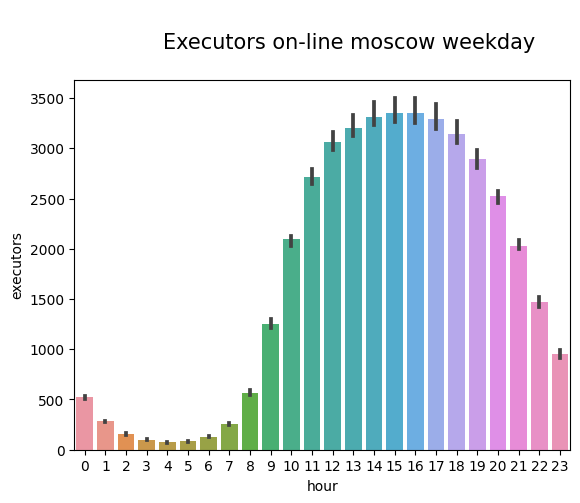

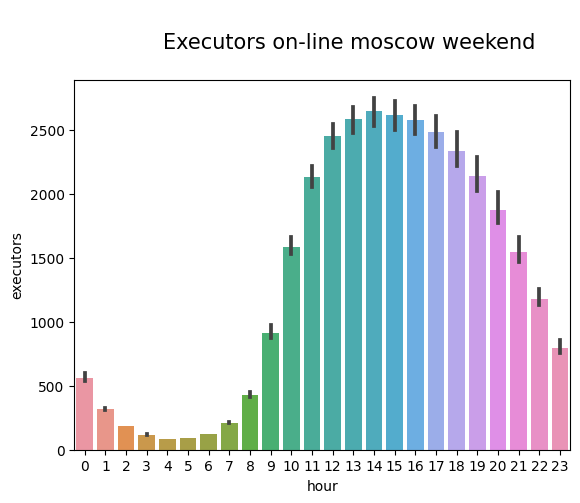

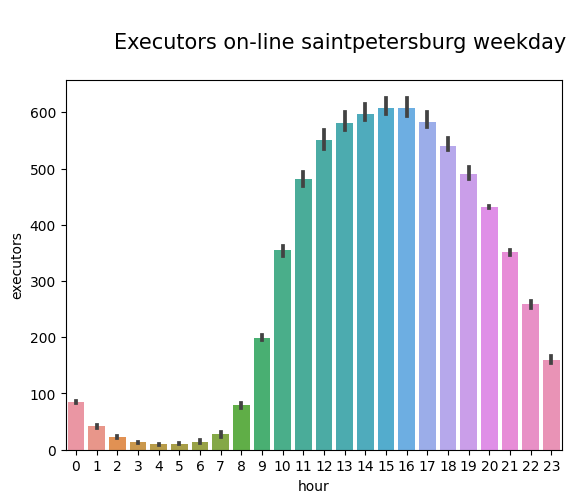

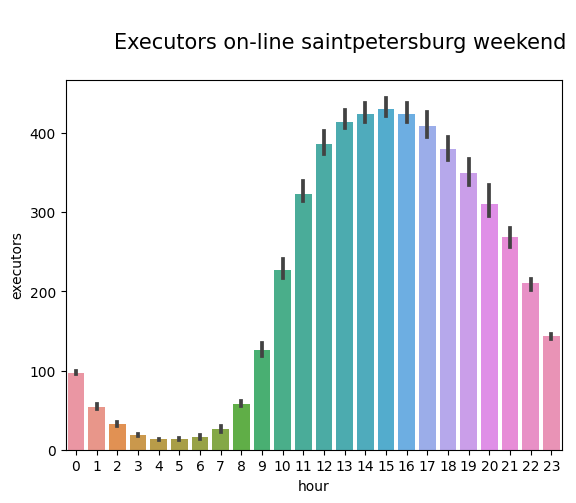

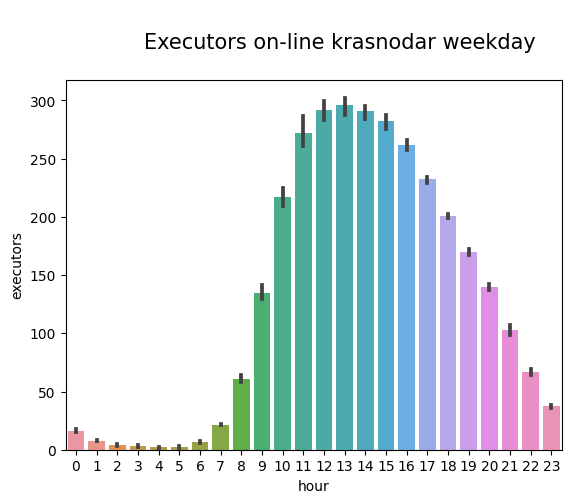

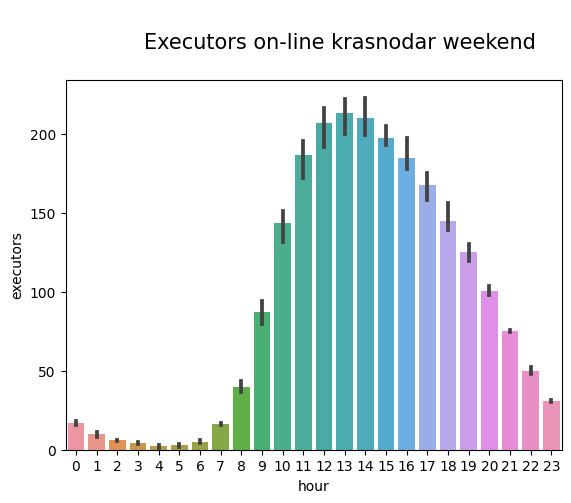

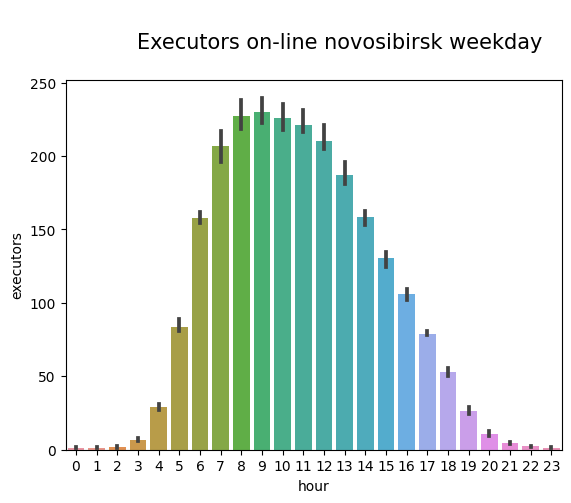

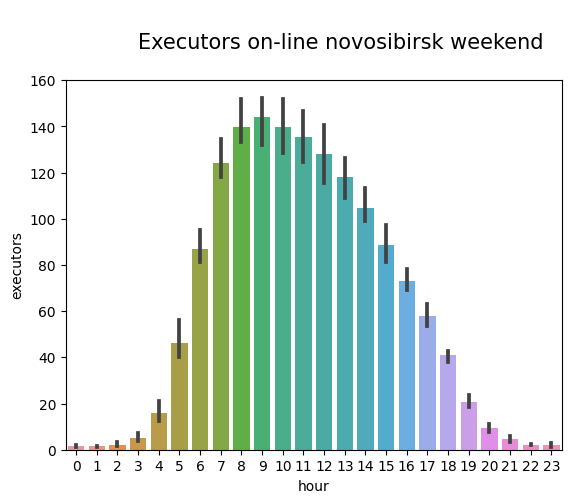

In [147]:
for node in regions['br']:
    for weekday in ss_df.is_weekend.unique():
#         print(ss_df[(ss_df.agglomeration_geo_node_id == node)&(ss_df.is_weekend == weekday)])
        i_df = ss_df[(ss_df.agglomeration_geo_node_id == node)&(ss_df.is_weekend == weekday)]
#         sns.barplot(data=i_df, x="hour", y="executors")
        
        ax = sns.barplot(data=i_df, x="hour", y="executors")
        ax.set_title(f'''
        Executors on-line {node.split('_')[1]} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)
        
        plt.show()

## утилизация

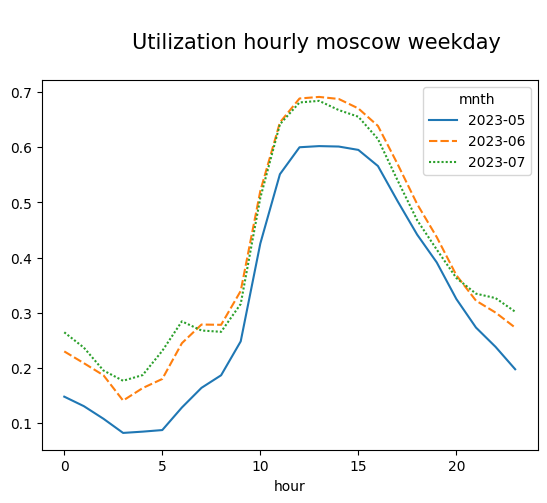

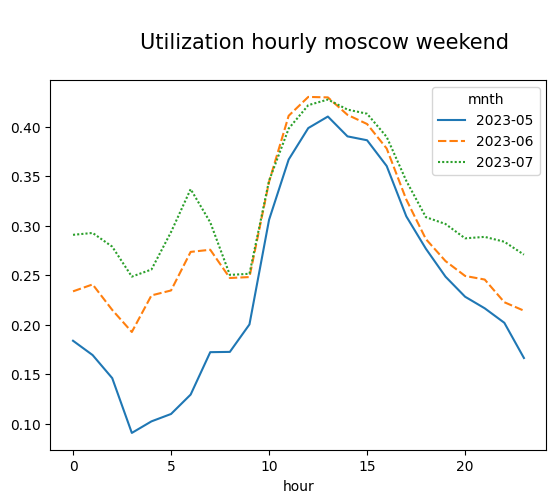

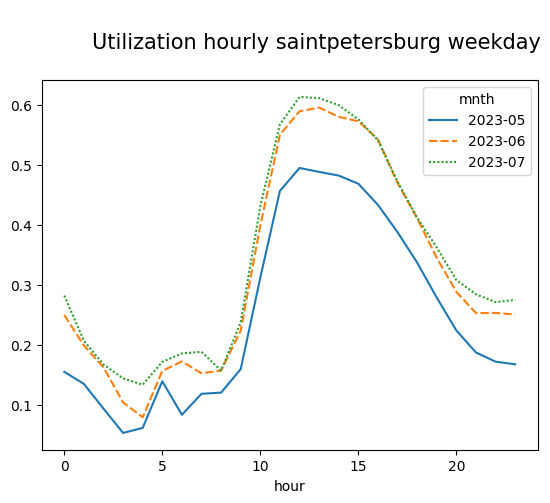

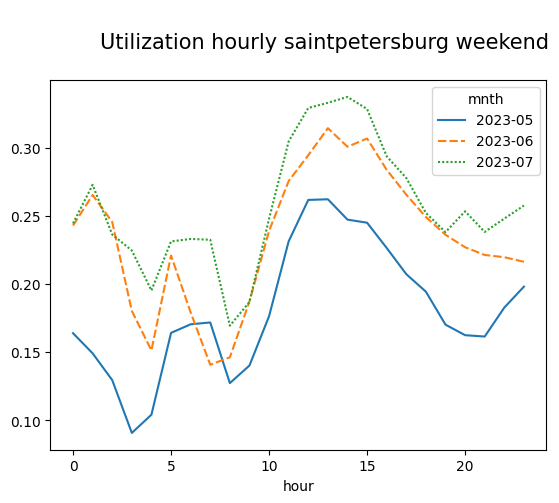

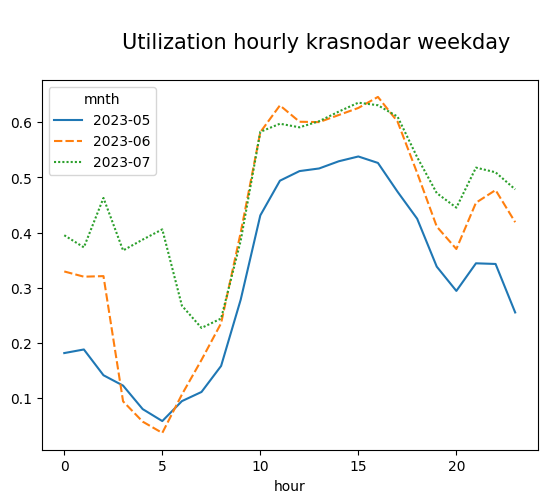

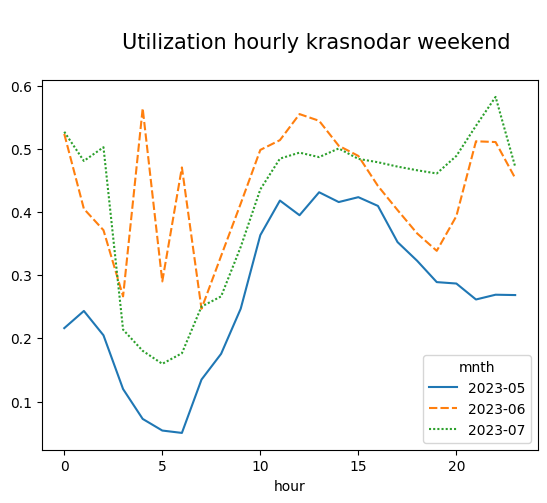

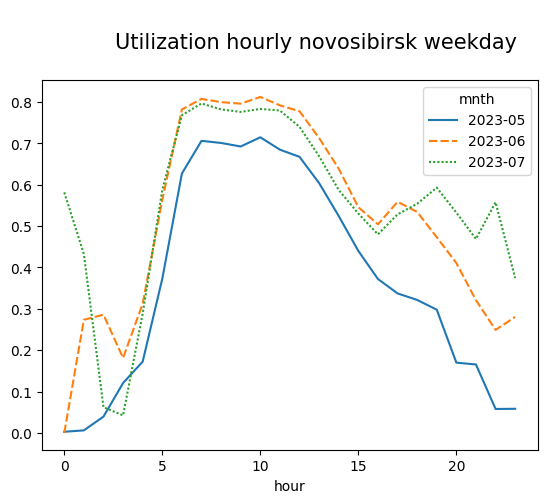

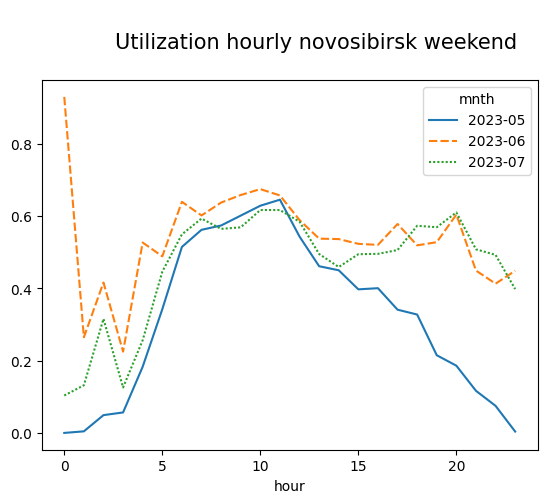

In [148]:
for node in regions['br']:
    for weekday in ss_df.is_weekend.unique():
#         print(ss_df[(ss_df.agglomeration_geo_node_id == node)&(ss_df.is_weekend == weekday)])
        i_df = ss_df[(ss_df.agglomeration_geo_node_id == node)&(ss_df.is_weekend == weekday)].pivot(
            index='hour', columns='mnth', values='util')

        # line,ax = plt.subplots() 
        ax = sns.lineplot(data=i_df)
        ax.set_title(f'''
        Utilization hourly {node.split('_')[1]} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)

        plt.show()

In [12]:
hourly_data.client_type

AttributeError: 'DataFrame' object has no attribute 'client_type'

In [24]:
hourly_data

claim_uuid client_type  \
0        00001f497f80402185c9a672eeddabd8         C2C   
1        000020bc99264bb3b7fc1a8cd9fcba05         C2C   
2        00002623b0b74ae2859f69c4834881b3         B2B   
3        000027abfa2a48fc9ce36cfa20449745         C2C   
4        000027c4612a443ca64c3138f7138af2         C2C   
...                                   ...         ...   
1759302  ffffe3e165254a99999165bb5be558cb         C2C   
1759303  fffff1a8660147069d25143a6707fe3a         C2C   
1759304  fffff6299c70431f8fca6ab112937b92         C2C   
1759305  fffffb7f71434c5bb42c69ee24b6b495         C2C   
1759306  fffffcc5d72e4db8a316621614cb03d7         C2C   

                                 order_id msk_created_timeslot  \
0        490b463c2e44bddd93e7740380352a0e  2023-07-31 19:00:00   
1        aee7cfca0901bafba7b715514d0b5155  2023-06-15 11:00:00   
2        64ce577488c5c86e91a7556d2a563770  2023-05-30 07:00:00   
3        fa88fde01c9fce58890759dbd855f73b  2023-07-27 22:00:00   
4        bc3a4f181d47d6c8afa2f5ff312d2ff5  2023-07-26 16:00:00   
...                                   ...                  ...   
1759302  3dd5e0db5c938f7ab983dc7f8c3485f2  2023-07-16 15:00:00   
1759303  fa9960af0da41f09ae72f5bac0975be8  2023-07-21 09:00:00   
1759304  1be15a850cb3ed499326d841cec754c4  2023-06-18 12:00:00   
1759305  6b9903fbd97be1a0aad7fd4892c507f1  2023-05-05 12:00:00   
1759306  c515bb1caed7e099a3a5edf0263de1ec  2023-05-15 09:00:00   

         delivered_finish source_city_name_en  user_cost  client_surge  \
0                       1              Moscow     2191.0           0.0   
1                       1           Krasnodar     1023.0         240.0   
2                       1              Moscow     2228.0           0.0   
3                       1              Moscow     1121.0           0.0   
4                       1              Moscow     1905.0           0.0   
...                   ...                 ...        ...           ...   
1759302                 1    Saint-Petersburg      854.0           0.0   
1759303                 1    Saint-Petersburg     1329.0           0.0   
1759304                 1              Moscow      973.0         110.0   
1759305                 1    Saint-Petersburg     4249.0         260.0   
1759306                 1              Moscow     1535.0           0.0   

         offer_seen  offer_accepted  assign  is_weekend     mnth  hour  \
0               1.0             1.0       1           0  2023-07    19   
1               1.0             1.0       1           0  2023-06    11   
2               1.0             1.0       1           0  2023-05     7   
3               4.0             1.0       1           0  2023-07    22   
4               1.0             1.0       1           0  2023-07    16   
...             ...             ...     ...         ...      ...   ...   
1759302         1.0             1.0       1           1  2023-07    15   
1759303         1.0             1.0       1           0  2023-07     9   
1759304         1.0             1.0       1           1  2023-06    12   
1759305         4.0             1.0       1           0  2023-05    12   
1759306         1.0             1.0       1           0  2023-05     9   

         is_surge  
0               0  
1               1  
2               0  
3               0  
4               0  
...           ...  
1759302         0  
1759303         0  
1759304         1  
1759305         1  
1759306         0  

[1758837 rows x 15 columns]

In [25]:
weekday = 1

hd_agg_success_t = hourly_data[hourly_data['delivered_finish']==1].groupby([
    'source_city_name_en', 'mnth', 'is_weekend', 'hour', 'client_type']).agg(
    claims=('claim_uuid', 'count'), surge_claims=('is_surge', 'sum'),
    delivered_finish=('delivered_finish', 'sum'), offer_seen=('offer_seen', 'sum'),
    offer_accepted=('offer_accepted', 'sum'), courier_found=('assign', 'sum'),).reset_index()

hd_agg_success_t['surge_share'] = hd_agg_success_t['surge_claims'] / hd_agg_success_t['claims']
hd_agg_success_t['cr'] = hd_agg_success_t['delivered_finish'] / hd_agg_success_t['claims']
hd_agg_success_t['ar'] = hd_agg_success_t['offer_accepted'] / hd_agg_success_t['offer_seen']
hd_agg_success_t['courier_not_found'] = 1 - (hd_agg_success_t['courier_found'] / hd_agg_success_t['claims'])

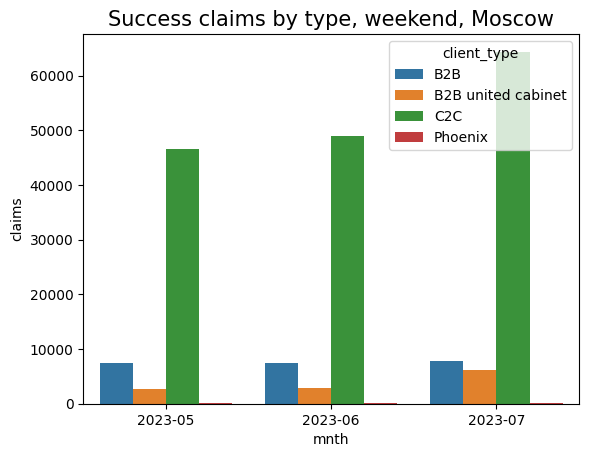

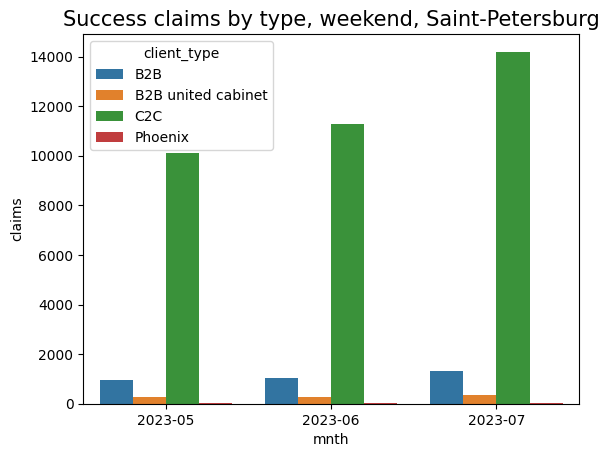

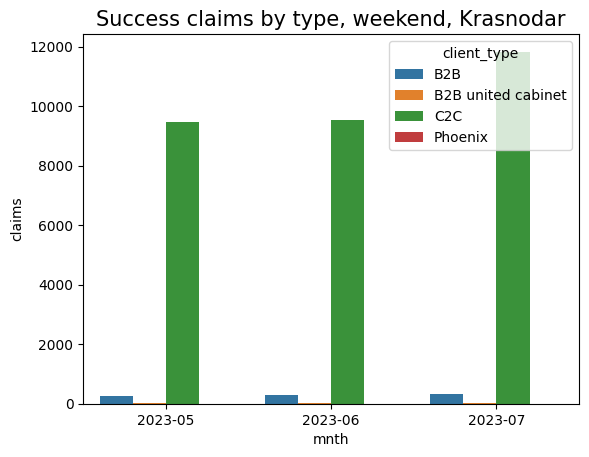

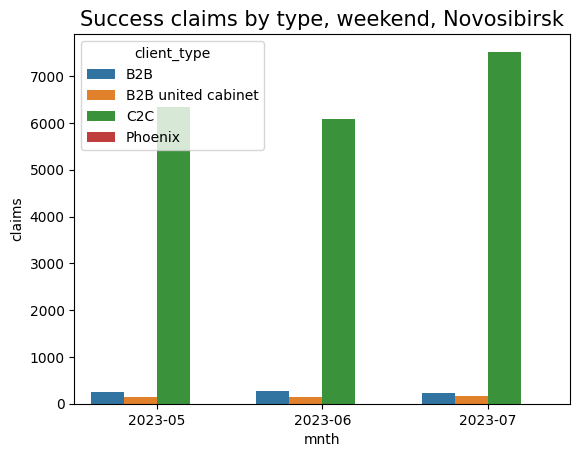

In [37]:
for node in regions['cities']:
    i_df = hd_agg_success_t[(hd_agg_success_t['source_city_name_en'] == node)&(
        hd_agg_success_t['is_weekend'] == weekday)]
    i_df_agg = i_df.groupby(['mnth', 'client_type']).claims.sum().reset_index()
    ax = sns.barplot(data=i_df_agg, x="mnth", y="claims", hue="client_type")
    ax.set_title(f'Success claims by type, weekend, {node}', fontsize=15)
    plt.show()

In [12]:
hd_agg_success = hourly_data[hourly_data['delivered_finish']==1].groupby([
    'source_city_name_en', 'mnth', 'is_weekend', 'hour']).agg(
    claims=('claim_uuid', 'count'), surge_claims=('is_surge', 'sum'),
    delivered_finish=('delivered_finish', 'sum'), offer_seen=('offer_seen', 'sum'),
    offer_accepted=('offer_accepted', 'sum'), courier_found=('assign', 'sum'),).reset_index()

hd_agg_success['surge_share'] = hd_agg_success['surge_claims'] / hd_agg_success['claims']
hd_agg_success['cr'] = hd_agg_success['delivered_finish'] / hd_agg_success['claims']
hd_agg_success['ar'] = hd_agg_success['offer_accepted'] / hd_agg_success['offer_seen']
hd_agg_success['courier_not_found'] = 1 - (hd_agg_success['courier_found'] / hd_agg_success['claims'])

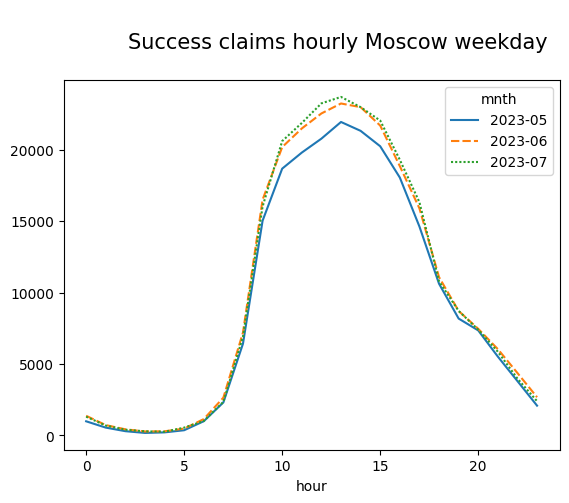

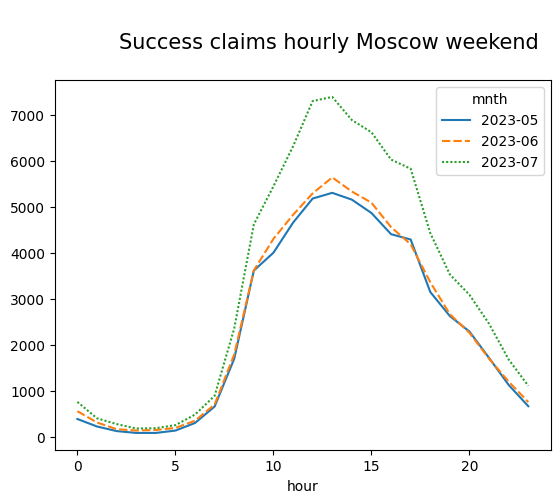

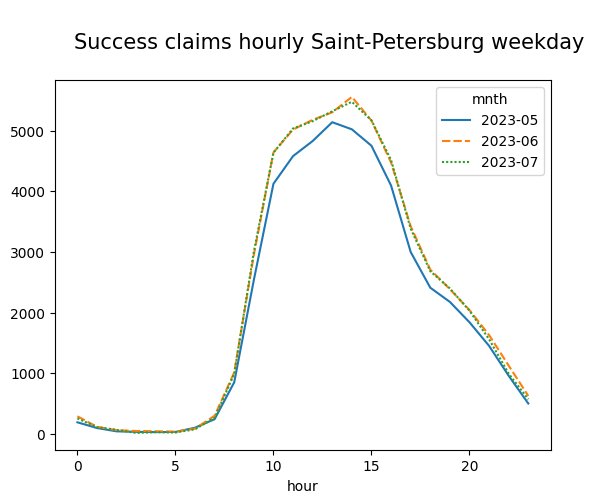

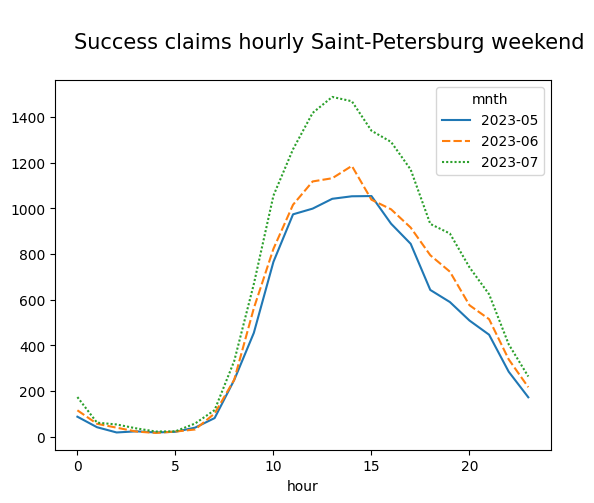

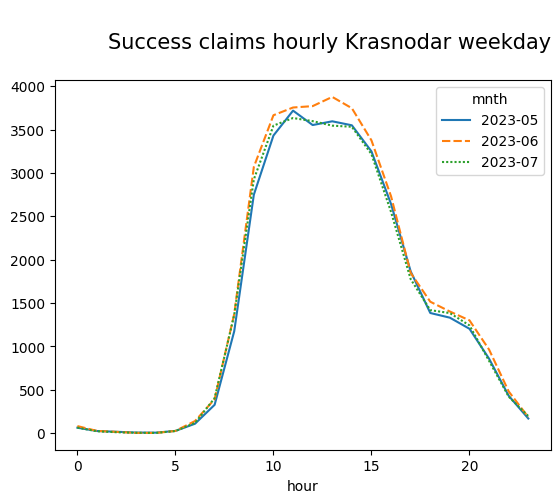

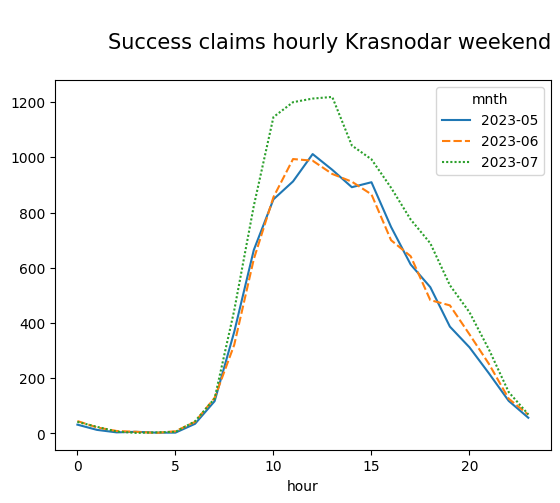

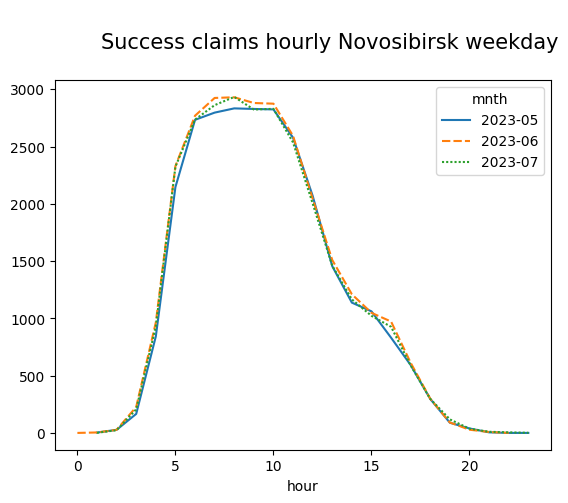

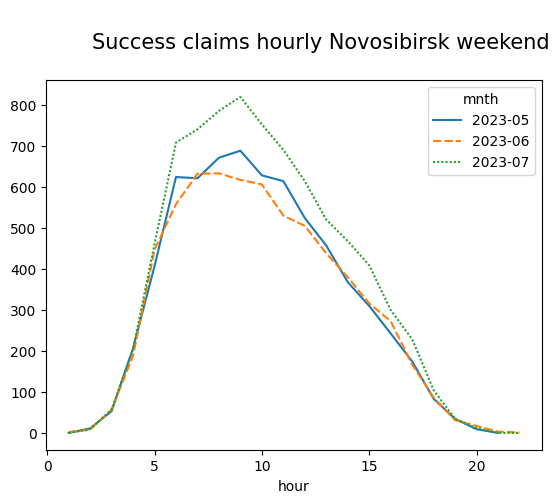

In [17]:
for node in regions['cities']:
    for weekday in hourly_data.is_weekend.unique():
        i_df = hd_agg_success[(hd_agg_success['source_city_name_en'] == node)&(
            hd_agg_success['is_weekend'] == weekday)].pivot(
            index='hour', columns='mnth', values='claims')
        
        ax = sns.lineplot(data=i_df)
        ax.set_title(f'''
        Success сlaims hourly {node} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)

        plt.show()

In [245]:
hd_agg = hourly_data.groupby(['source_city_name_en', 'mnth', 'is_weekend', 'hour']).agg(
    claims=('claim_uuid', 'count'), surge_claims=('is_surge', 'sum'),
    delivered_finish=('delivered_finish', 'sum'), offer_seen=('offer_seen', 'sum'),
    offer_accepted=('offer_accepted', 'sum'), courier_found=('assign', 'sum'),).reset_index()

hd_agg['surge_share'] = hd_agg['surge_claims'] / hd_agg['claims']
hd_agg['cr'] = hd_agg['delivered_finish'] / hd_agg['claims']
hd_agg['ar'] = hd_agg['offer_accepted'] / hd_agg['offer_seen']
hd_agg['courier_not_found'] = 1 - (hd_agg['courier_found'] / hd_agg['claims'])

In [246]:
hd_agg

source_city_name_en     mnth  is_weekend  hour  claims  surge_claims  \
0             Krasnodar  2023-05           0     0     129            15   
1             Krasnodar  2023-05           0     1      63            12   
2             Krasnodar  2023-05           0     2      37             5   
3             Krasnodar  2023-05           0     3      22             2   
4             Krasnodar  2023-05           0     4      19             3   
..                  ...      ...         ...   ...     ...           ...   
569    Saint-Petersburg  2023-07           1    19    1172           222   
570    Saint-Petersburg  2023-07           1    20    1027           196   
571    Saint-Petersburg  2023-07           1    21     834           178   
572    Saint-Petersburg  2023-07           1    22     593           164   
573    Saint-Petersburg  2023-07           1    23     384           124   

     delivered_finish  offer_seen  offer_accepted  courier_found  surge_share  \
0                  64       159.0           103.0            103     0.116279   
1                  26        73.0            47.0             47     0.190476   
2                  17        41.0            27.0             27     0.135135   
3                   8        24.0            15.0             15     0.090909   
4                   7        25.0            10.0             10     0.157895   
..                ...         ...             ...            ...          ...   
569               890      1406.0          1129.0           1129     0.189420   
570               742      1245.0           967.0            967     0.190847   
571               624      1008.0           780.0            780     0.213429   
572               405       751.0           547.0            547     0.276560   
573               264       499.0           356.0            356     0.322917   

           cr        ar  courier_not_found  
0    0.496124  0.647799           0.201550  
1    0.412698  0.643836           0.253968  
2    0.459459  0.658537           0.270270  
3    0.363636  0.625000           0.318182  
4    0.368421  0.400000           0.473684  
..        ...       ...                ...  
569  0.759386  0.802987           0.036689  
570  0.722493  0.776707           0.058423  
571  0.748201  0.773810           0.064748  
572  0.682968  0.728362           0.077572  
573  0.687500  0.713427           0.072917  

[574 rows x 14 columns]

# сколько заявок

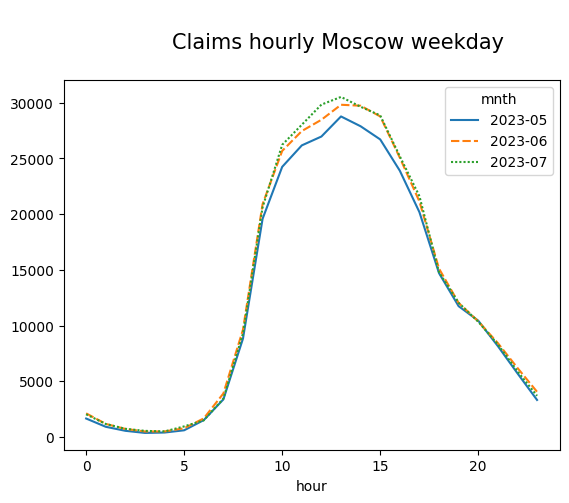

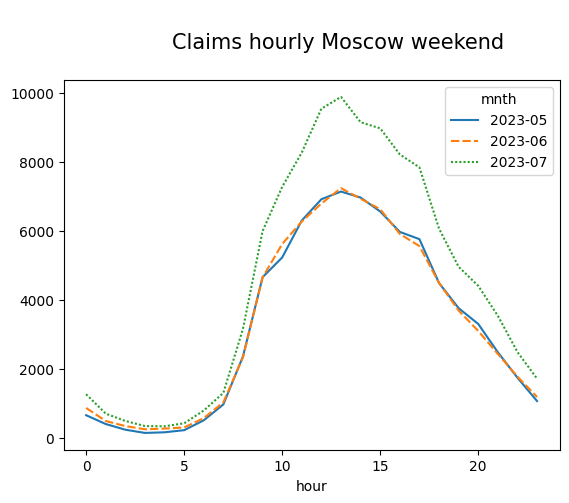

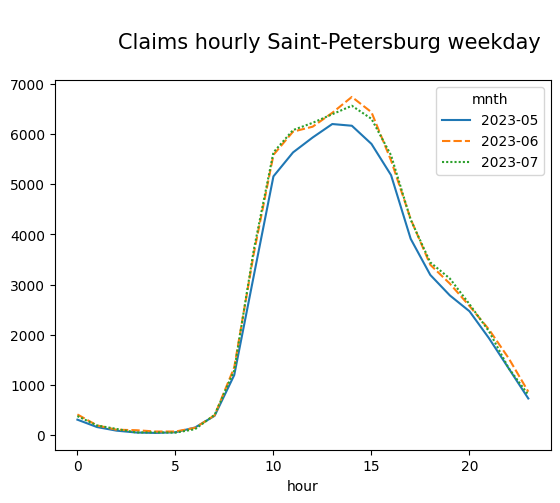

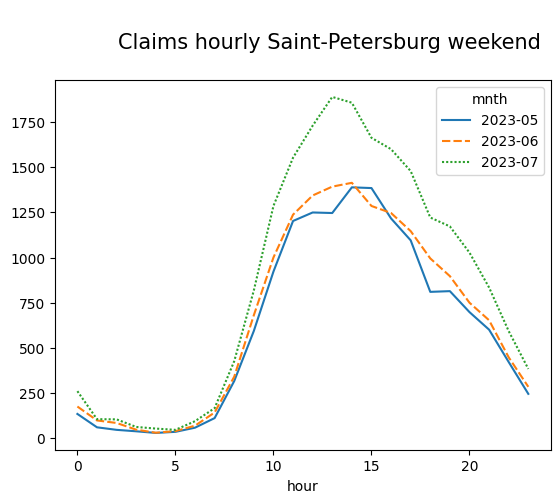

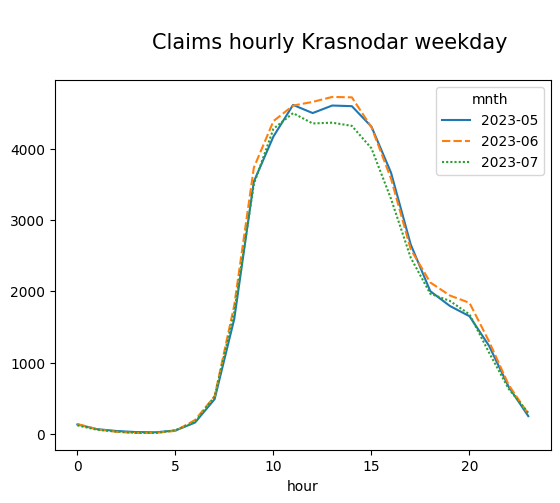

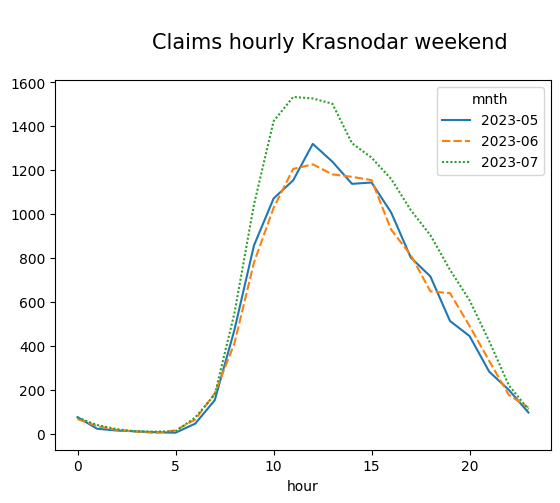

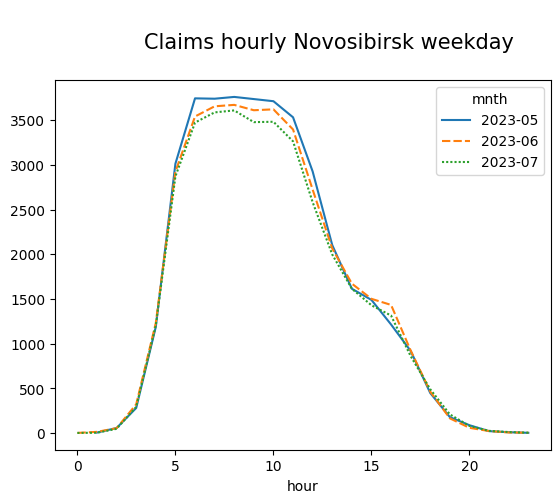

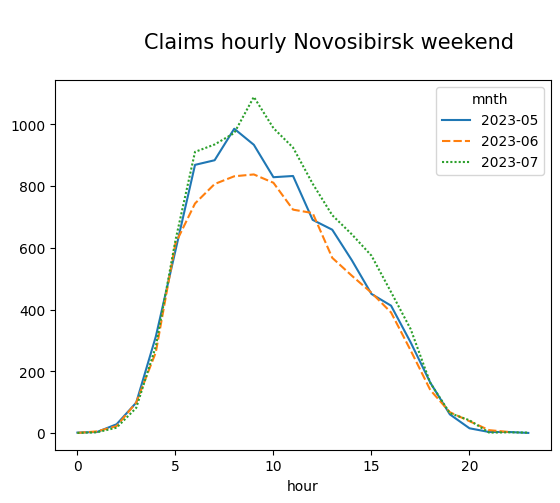

In [248]:
for node in regions['cities']:
    for weekday in hourly_data.is_weekend.unique():
        i_df = hd_agg[(hd_agg['source_city_name_en'] == node)&(hd_agg['is_weekend'] == weekday)].pivot(
            index='hour', columns='mnth', values='claims')
        
        ax = sns.lineplot(data=i_df)
        ax.set_title(f'''
        Claims hourly {node} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)

        plt.show()

# уровень суржа

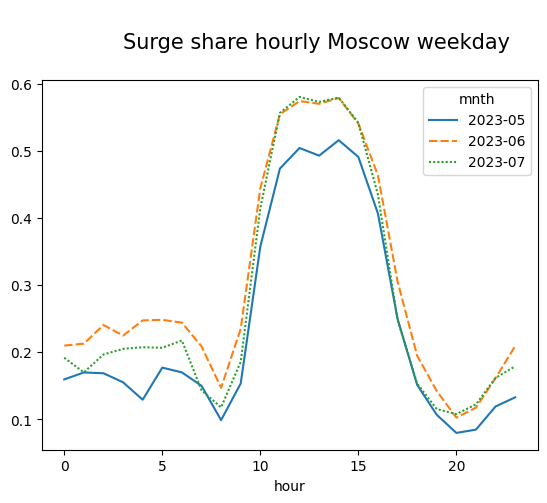

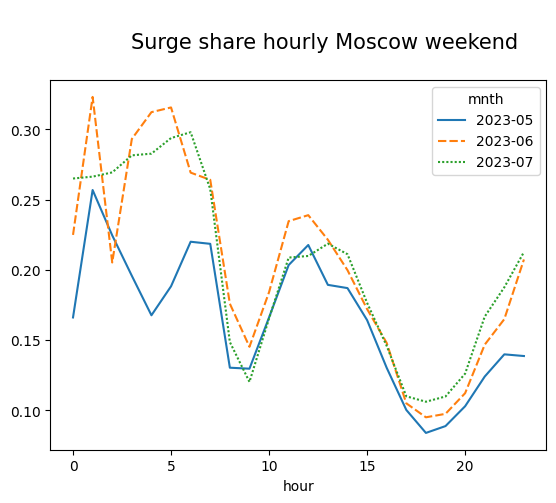

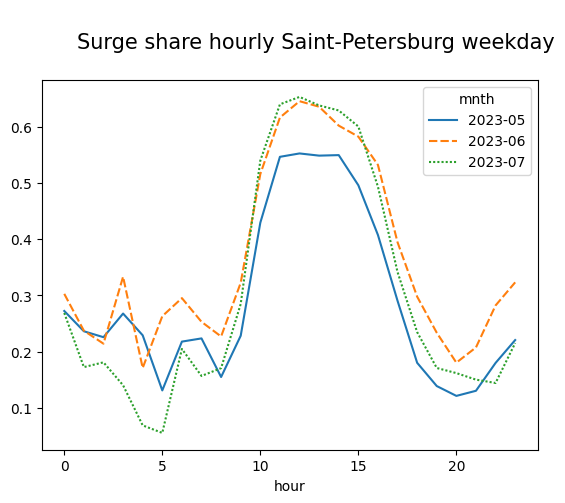

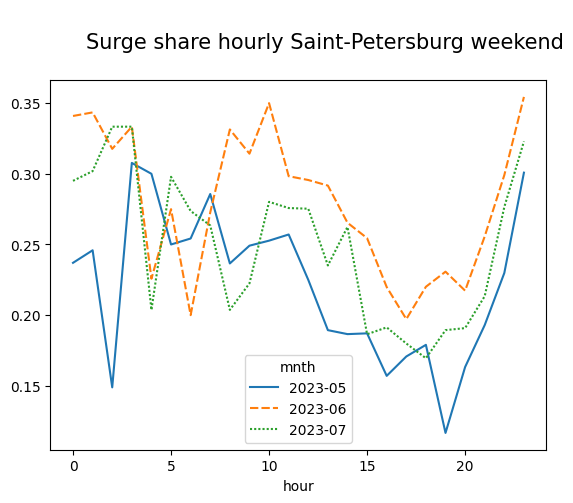

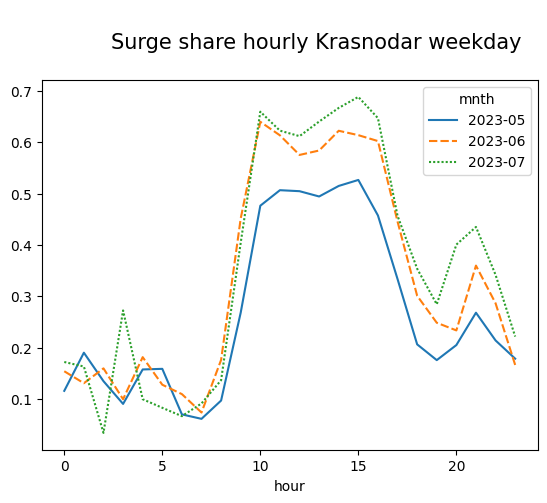

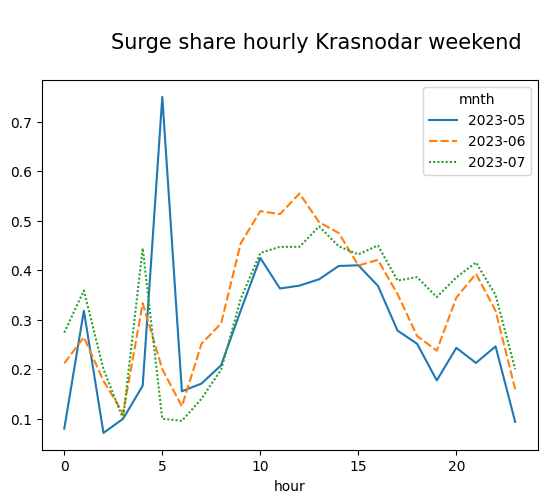

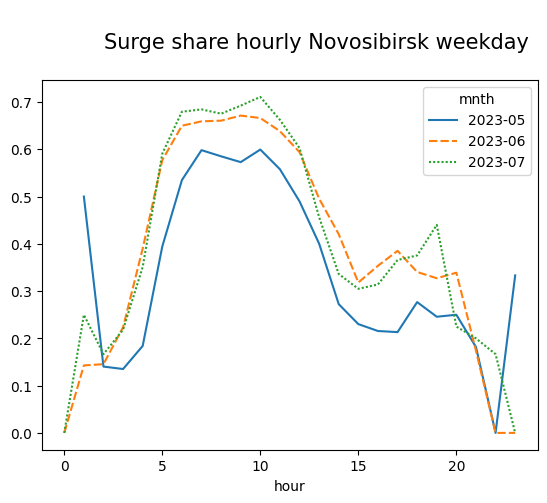

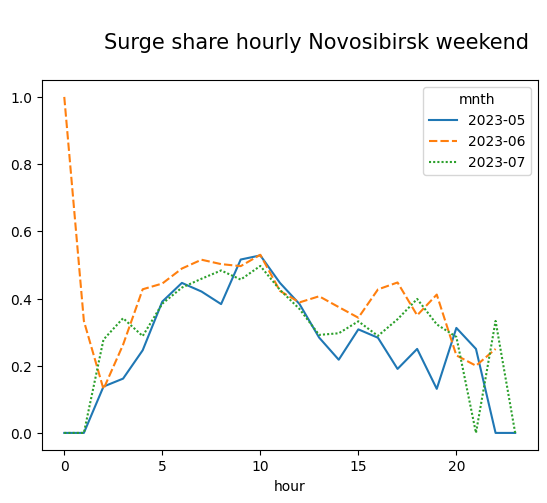

In [249]:
for node in regions['cities']:
    for weekday in hourly_data.is_weekend.unique():
        i_df = hd_agg[(hd_agg['source_city_name_en'] == node)&(hd_agg['is_weekend'] == weekday)].pivot(
            index='hour', columns='mnth', values='surge_share')
        
        ax = sns.lineplot(data=i_df)
        ax.set_title(f'''
        Surge share hourly {node} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)

        plt.show()

### Доля сурджа на заказах (с сурджом)

In [206]:
surge_df = hourly_data[hourly_data['is_surge']==1][['source_city_name_en', 'user_cost', 'client_surge']]
surge_df['surge_share'] = surge_df['client_surge'] / surge_df['user_cost']

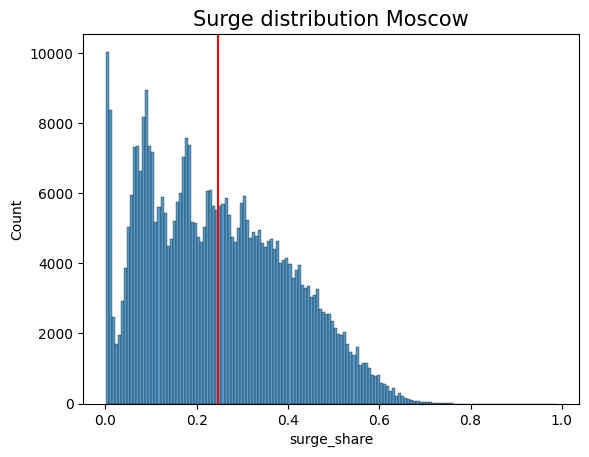

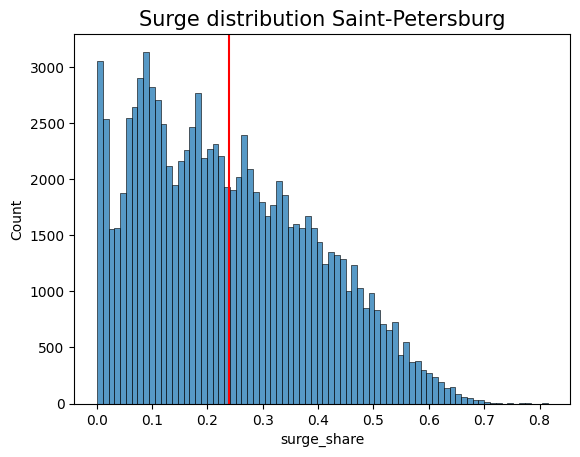

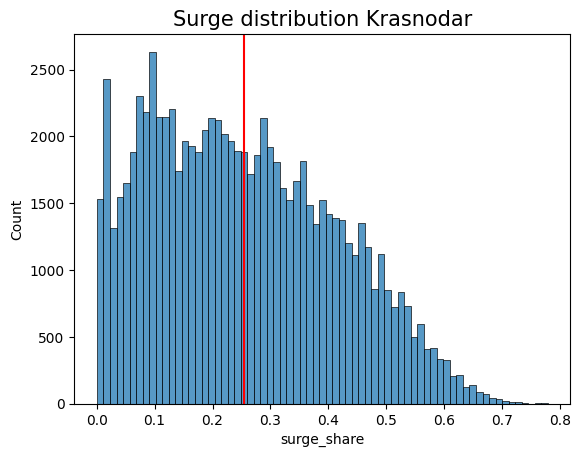

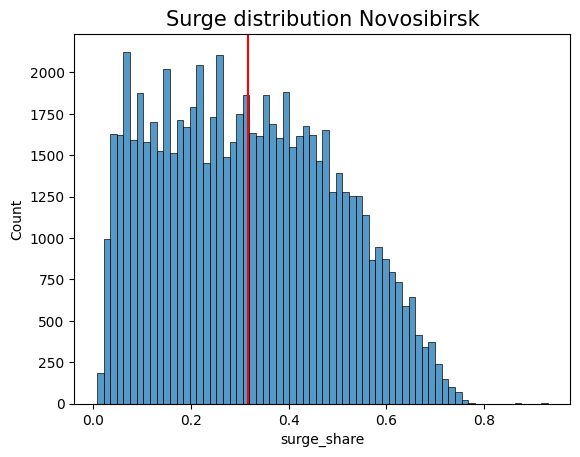

In [219]:
for node in regions['cities']:
    i_df = surge_df[surge_df['source_city_name_en'] == node]
    
    ax = sns.histplot(i_df[i_df['surge_share']<1]['surge_share'])
    ax.set_title(f'Surge distribution {node}', fontsize=15)
    ax.axvline(i_df[i_df['surge_share']<1]["surge_share"].mean(), color = "red")
    
    plt.show()

# полный CR, AR

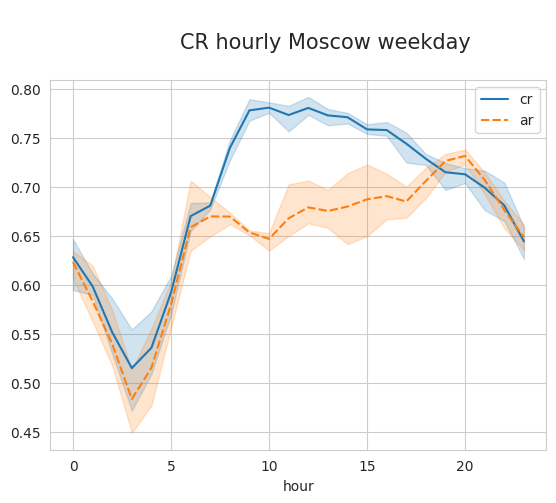

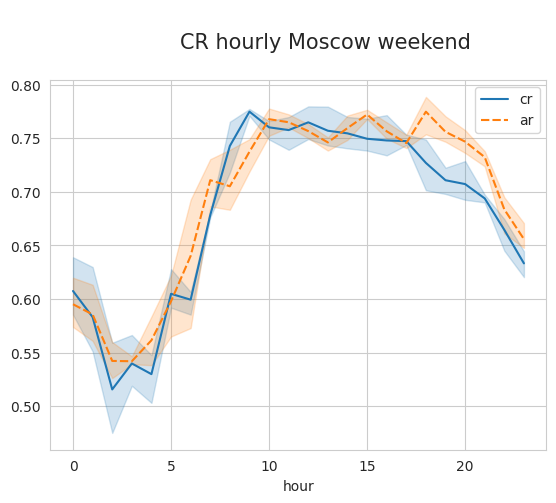

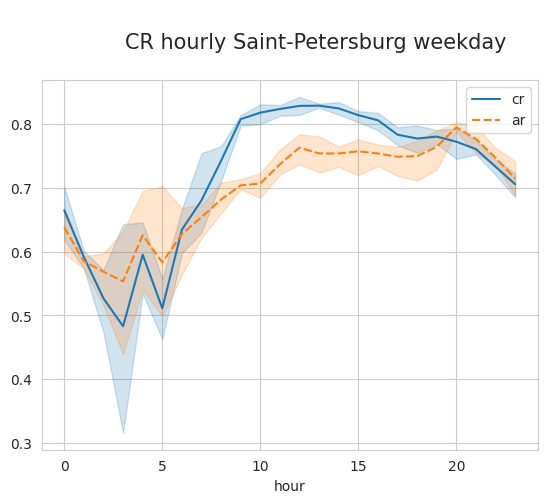

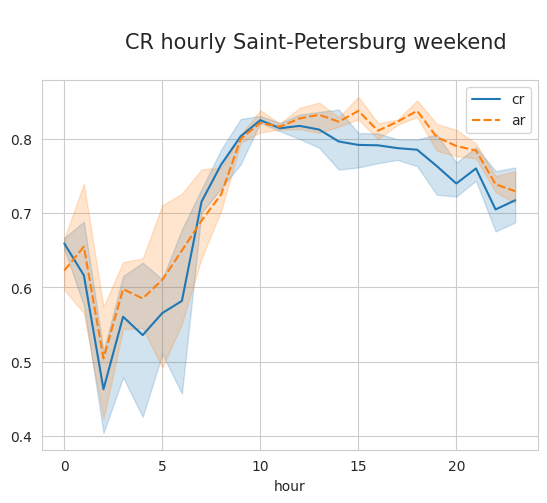

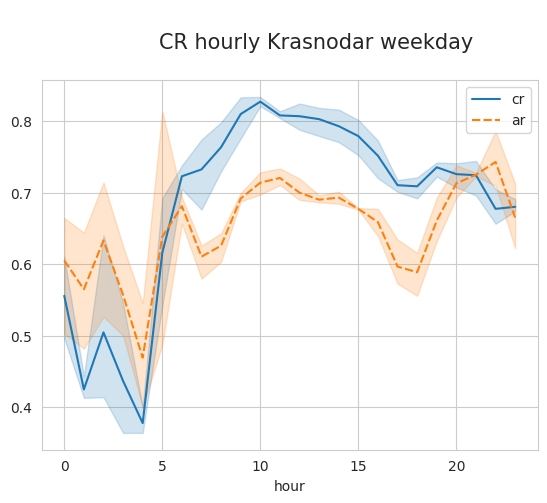

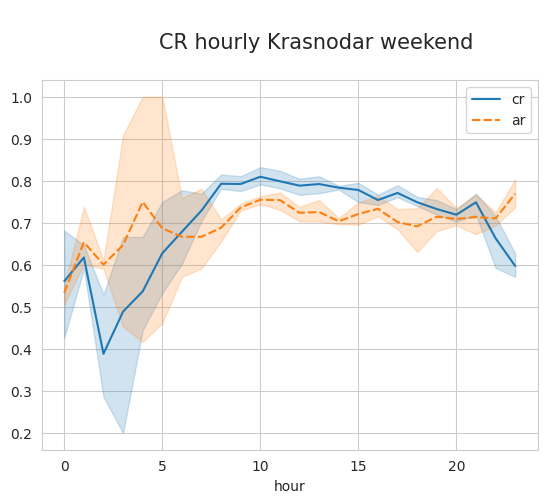

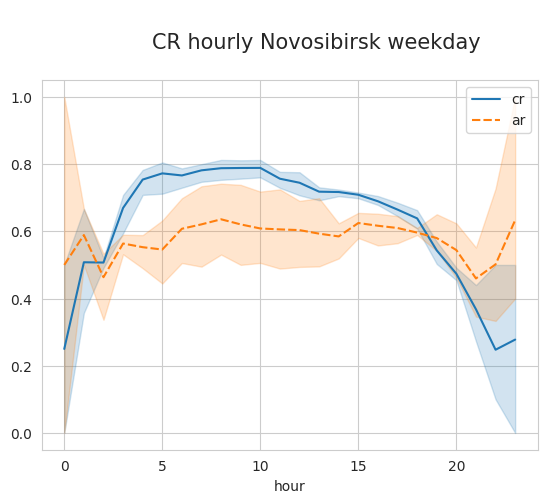

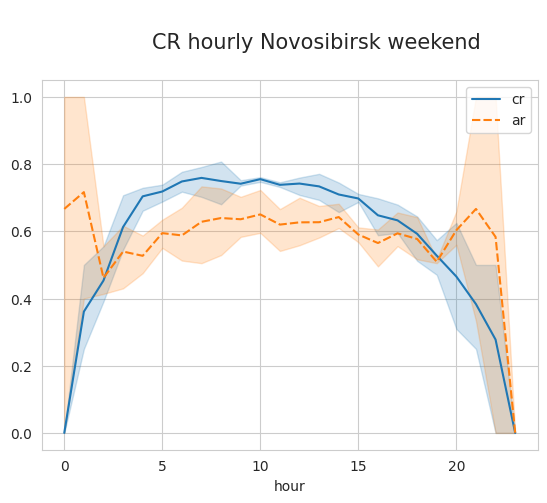

In [256]:
for node in regions['cities']:
    for weekday in hourly_data.is_weekend.unique():
        i_df = hd_agg[(hd_agg['source_city_name_en'] == node)&(hd_agg['is_weekend'] == weekday)].pivot(
            index='hour', columns='mnth', values=['cr', 'ar'])
        
        
        sns.set_style("whitegrid")
        ax = sns.lineplot(data=i_df)
        
        ax.set_title(f'''
        CR hourly {node} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)

        plt.show()

# горение (не найден курьер)

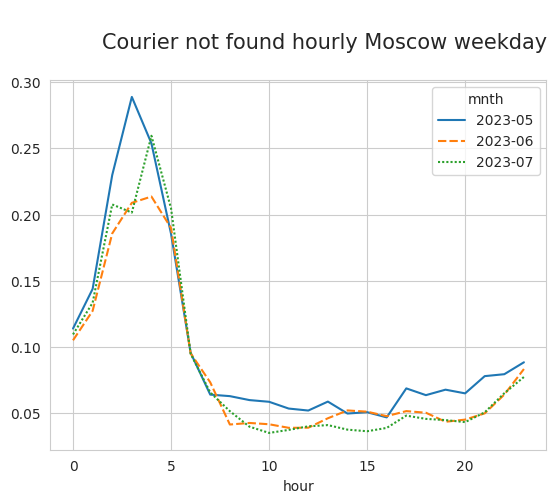

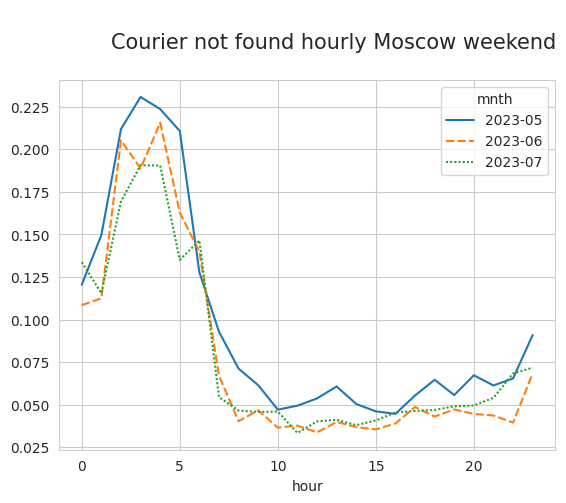

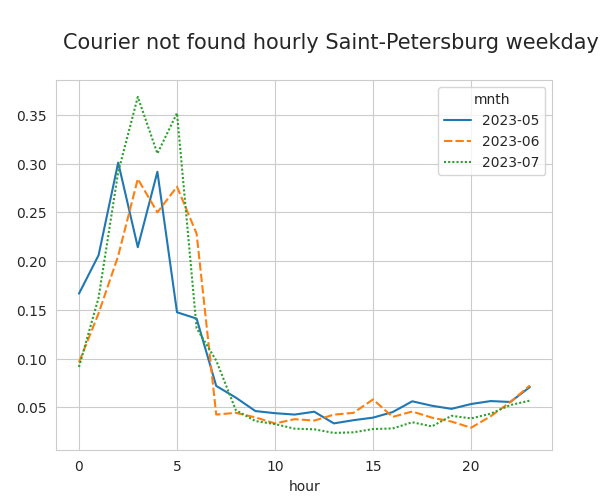

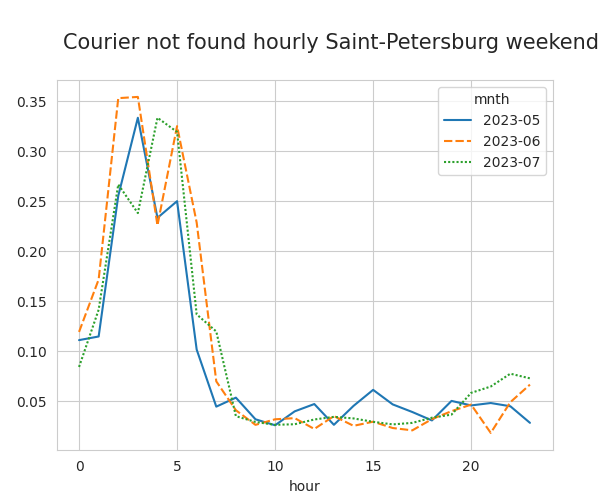

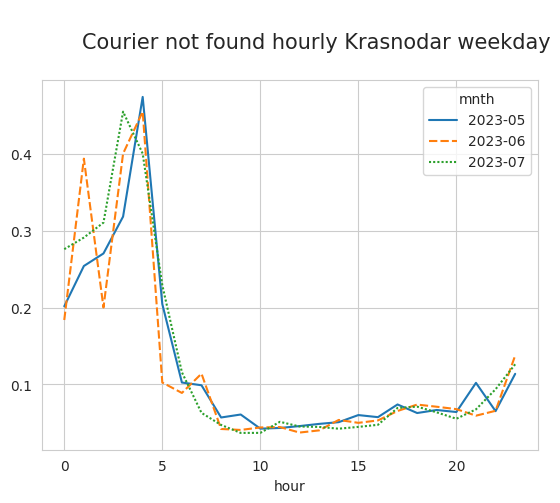

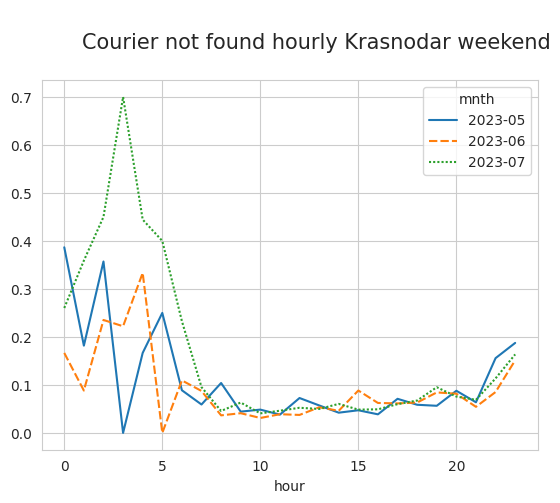

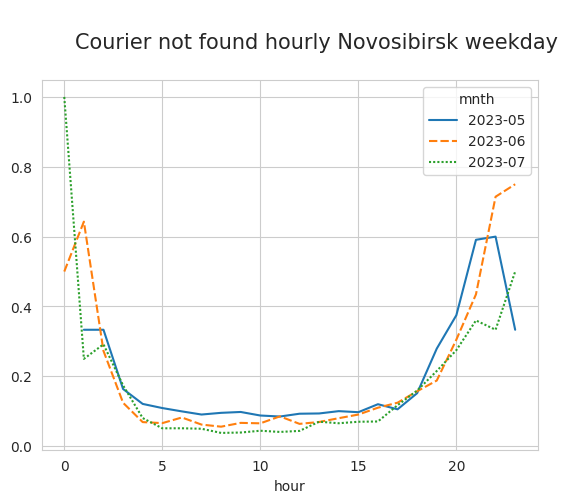

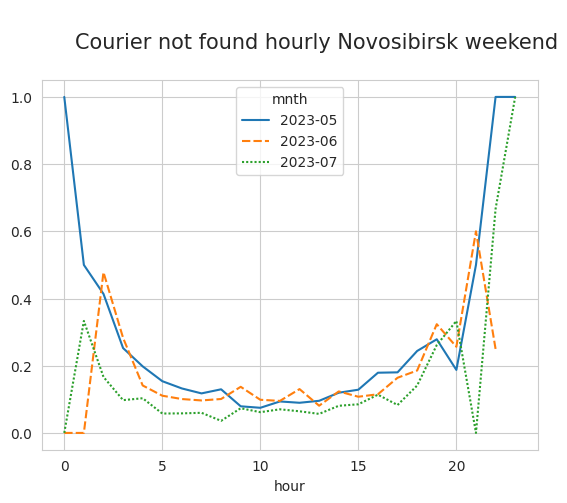

In [259]:
for node in regions['cities']:
    for weekday in hourly_data.is_weekend.unique():
        i_df = hd_agg[(hd_agg['source_city_name_en'] == node)&(hd_agg['is_weekend'] == weekday)].pivot(
            index='hour', columns='mnth', values='courier_not_found')
        
        
        sns.set_style("whitegrid")
        ax = sns.lineplot(data=i_df)
        
        ax.set_title(f'''
        Courier not found hourly {node} {({0:'weekday', 1:'weekend'}).get(weekday)}
                     ''', fontsize=15)

        plt.show()

# Daily Scale

In [8]:
query = '''
    use hahn;
    
    $start_date = '2023-05-01';
    $end_date = '2023-07-01';

    $mph_dynamics = '//home/taxi-delivery/analytics/dev/gennadyand/sub_util/mph_dynamics_new';

    select agglomeration, mnth, park_taximeter_id, executor_profile_id, local_dt_str, 
        sum(driver_net_inflow) as driver_net_inflow,
        sum(total_sh) as total_sh,
        sum(driving_sh + waiting_sh + transporting_sh) as effective_sh
    from range($mph_dynamics, $start_date, $end_date)
    where 1=1
        and agglomeration in ('Moscow', 'Saint-Petersburg', 'Krasnodar', 'Novosibirsk')
        and courier_type = '6. cargo_courier'
    group by agglomeration, substring(local_dt_str,0,7) as mnth, park_taximeter_id, executor_profile_id, local_dt_str
    ;
        '''

In [9]:
df = hahn(query)

In [10]:
df = df[df['local_dt_str'] != '2023-08-01']

In [11]:
df['mph'] = df['driver_net_inflow'] / df['total_sh']

In [31]:
dni_data = {}
mph_data = {}

for node in regions['cities']:
    driver_net_inflow = df[(df['agglomeration']==node)&(df['driver_net_inflow']>0)].driver_net_inflow
    mph = df[(df['agglomeration']==node)&(df['driver_net_inflow']>0)&(df['total_sh']>0)].mph
    
#     dni = {'mean': int(driver_net_inflow.mean())}
    dni = {}
    dni.update({str(i)+'q':int(np.quantile(driver_net_inflow, i)) for i in [i/10 for i in range(1,10)]})
    dni_data.update({node: dni})
    
#     mph_i = {'mean': int(mph.mean())}
    mph_i = {}
    mph_i.update({str(i)+'q':int(np.quantile(mph, i)) for i in [i/10 for i in range(1,10)]})
    mph_data.update({node: mph_i})

In [20]:
mph_dni_agg = df[(df['driver_net_inflow']>0)&(df['total_sh']>0)].groupby(['agglomeration','mnth']).agg(
    driver_net_inflow=('driver_net_inflow', 'sum'), total_sh=('total_sh', 'sum'),
    driver_net_inflow_mean=('driver_net_inflow', 'mean'),).reset_index()

mph_dni_agg['mph'] = mph_dni_agg['driver_net_inflow'] / mph_dni_agg['total_sh']

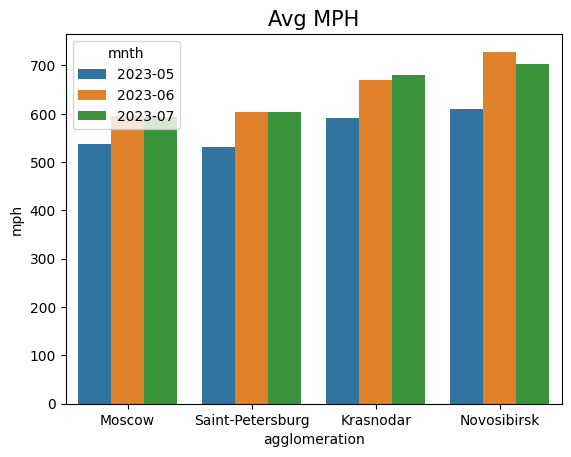

In [42]:
ax = sns.barplot(data=mph_dni_agg, x="agglomeration", y="mph", hue="mnth", order=regions['cities'])
ax.set_title(f'Avg MPH', fontsize=15)
plt.show()

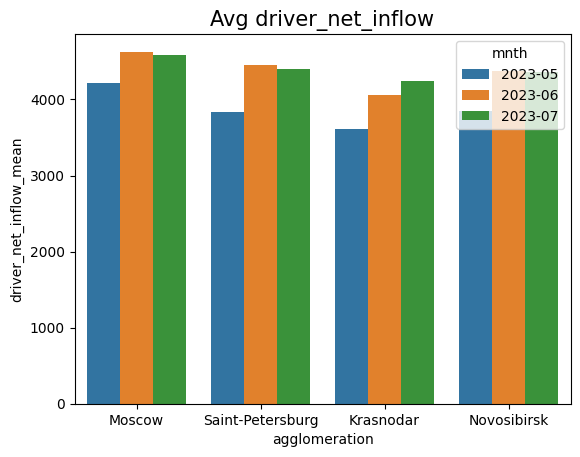

In [45]:
ax = sns.barplot(data=mph_dni_agg, x="agglomeration", y="driver_net_inflow_mean", hue="mnth",
                 order=regions['cities'])
ax.set_title(f'Avg driver_net_inflow', fontsize=15)
plt.show()

In [32]:
dni_data_df = pd.DataFrame(dni_data)
dni_data_df[dni_data_df.index != '0.0q']

Moscow  Saint-Petersburg  Krasnodar  Novosibirsk
0.1q    1167              1006        993         1130
0.2q    1810              1586       1530         1748
0.3q    2491              2190       2072         2383
0.4q    3205              2836       2641         3006
0.5q    3962              3545       3290         3664
0.6q    4749              4281       3972         4374
0.7q    5597              5146       4806         5162
0.8q    6692              6285       5865         6179
0.9q    8335              8113       7526         7771

In [33]:
mph_data_df = pd.DataFrame(mph_data)
mph_data_df[mph_data_df.index != '0.0q']

Moscow  Saint-Petersburg  Krasnodar  Novosibirsk
0.1q     256               244        299          358
0.2q     347               334        396          449
0.3q     417               406        471          517
0.4q     479               469        535          579
0.5q     538               534        600          639
0.6q     600               602        668          703
0.7q     673               686        749          779
0.8q     774               798        862          881
0.9q     966               997       1071         1055

In [46]:
df_agg = df[(df['driver_net_inflow']>0)&(df['total_sh']>0)].groupby([
    'agglomeration', 'mnth', 'park_taximeter_id', 'executor_profile_id'])[
    'driver_net_inflow','total_sh','effective_sh'].sum().reset_index()

df_agg['mph'] = df_agg['driver_net_inflow'] / df_agg['total_sh']

df_agg['dbid_uuid'] = df_agg['park_taximeter_id'] + '_' + df_agg['executor_profile_id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
df_agg = df_agg[df_agg.mph < df_agg.mph.mean() + df_agg.mph.std()*3]

## MPH

In [48]:
for node in regions['cities']:
    df_i = df_agg[df_agg['agglomeration']==node]

In [49]:
df_i

agglomeration     mnth                 park_taximeter_id  \
45662   Novosibirsk  2023-05  002b7de0bf6b4dffa58a166ffad732bf   
45663   Novosibirsk  2023-05  00582bf6bb4f4b59bd6812869089a97c   
45664   Novosibirsk  2023-05  00900b7dd8d344b4b6b581fefca1db96   
45665   Novosibirsk  2023-05  01a607dc7f80415ea88d6338ab04aefb   
45666   Novosibirsk  2023-05  02a23f138c774b89a81534305979e8fe   
...             ...      ...                               ...   
48438   Novosibirsk  2023-07  fbd21e63c7224d5086591ceb55c14daf   
48439   Novosibirsk  2023-07  fdf77667d33247e7ba13d6d093b7269b   
48440   Novosibirsk  2023-07  fea680d44ef440d2838f4f8a2b3dcc74   
48441   Novosibirsk  2023-07  ff606ce91b5d4ad6be93bcb3a4ed4c52   
48442   Novosibirsk  2023-07  ffdf7f38f26344aebb0e9e1625b80cd8   

                    executor_profile_id  driver_net_inflow    total_sh  \
45662  56db6f6f280e42eaab850bb1a4b688ab        76712.94658  121.005000   
45663  3efae757100545e8916720e2904ac494          346.27220    1.448889   
45664  6920c4b271634dabadd77efa9e69eade        32020.83186   58.527500   
45665  656028e822a647019e64af6d9482caf6          843.88672    2.540000   
45666  34aee12e62ae4c96ab8782f86e1e155f         4640.89868   11.466389   
...                                 ...                ...         ...   
48438  58ad72199fb340218d2691cce97ce4f1         8607.53320   16.625833   
48439  33753af7dc024006a4b97135182a0d67        41323.46442   63.584722   
48440  1ff764a6b56dfaa21618bdcc8d298e2e       216566.69494  185.507778   
48441  a56c8b553ed8a1a201774b4a1a87d54d        74533.56816  135.681389   
48442  133594c0f4ac48c280be691f76159e8f        31514.42268   22.169722   

       effective_sh          mph  \
45662     86.561944   633.965097   
45663      0.411667   238.991549   
45664     36.807222   547.107460   
45665      1.941389   332.238866   
45666      9.750278   404.739341   
...             ...          ...   
48438      7.057222   517.720407   
48439     51.405000   649.896122   
48440    154.404444  1167.426496   
48441     60.973889   549.327869   
48442     17.015000  1421.507332   

                                               dbid_uuid  
45662  002b7de0bf6b4dffa58a166ffad732bf_56db6f6f280e4...  
45663  00582bf6bb4f4b59bd6812869089a97c_3efae75710054...  
45664  00900b7dd8d344b4b6b581fefca1db96_6920c4b271634...  
45665  01a607dc7f80415ea88d6338ab04aefb_656028e822a64...  
45666  02a23f138c774b89a81534305979e8fe_34aee12e62ae4...  
...                                                  ...  
48438  fbd21e63c7224d5086591ceb55c14daf_58ad72199fb34...  
48439  fdf77667d33247e7ba13d6d093b7269b_33753af7dc024...  
48440  fea680d44ef440d2838f4f8a2b3dcc74_1ff764a6b56df...  
48441  ff606ce91b5d4ad6be93bcb3a4ed4c52_a56c8b553ed8a...  
48442  ffdf7f38f26344aebb0e9e1625b80cd8_133594c0f4ac4...  

[2780 rows x 9 columns]

In [54]:
df_i[df_i['mnth']=='2023-05']['effective_sh'].sum() / df_i[df_i['mnth']=='2023-05']['total_sh'].sum()

0.6508715776102878

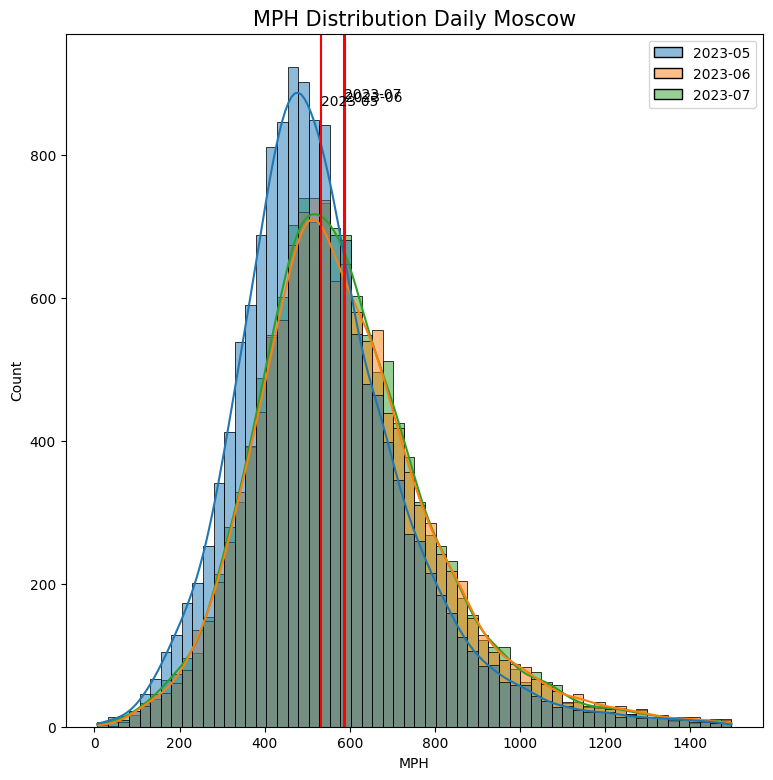

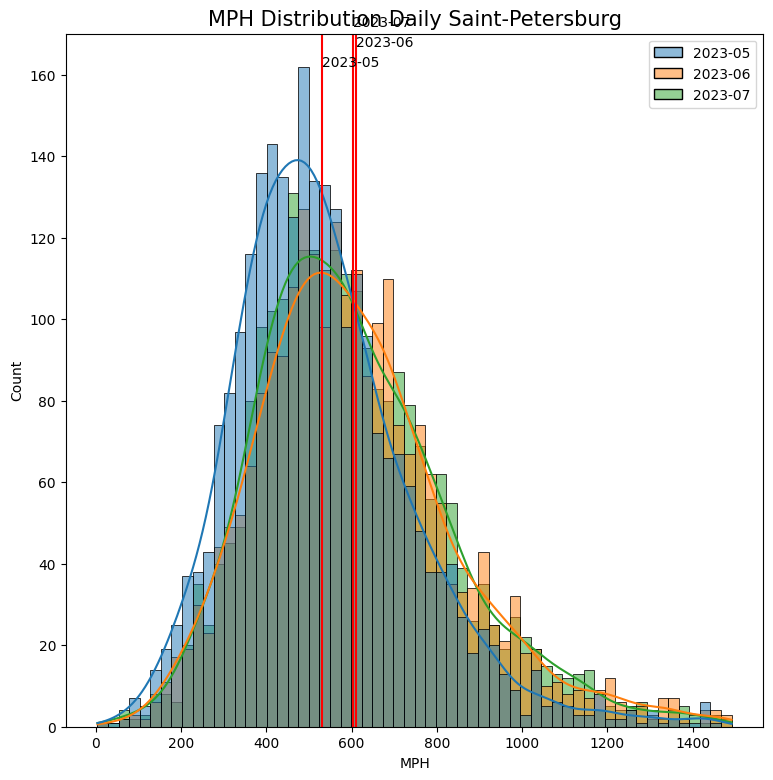

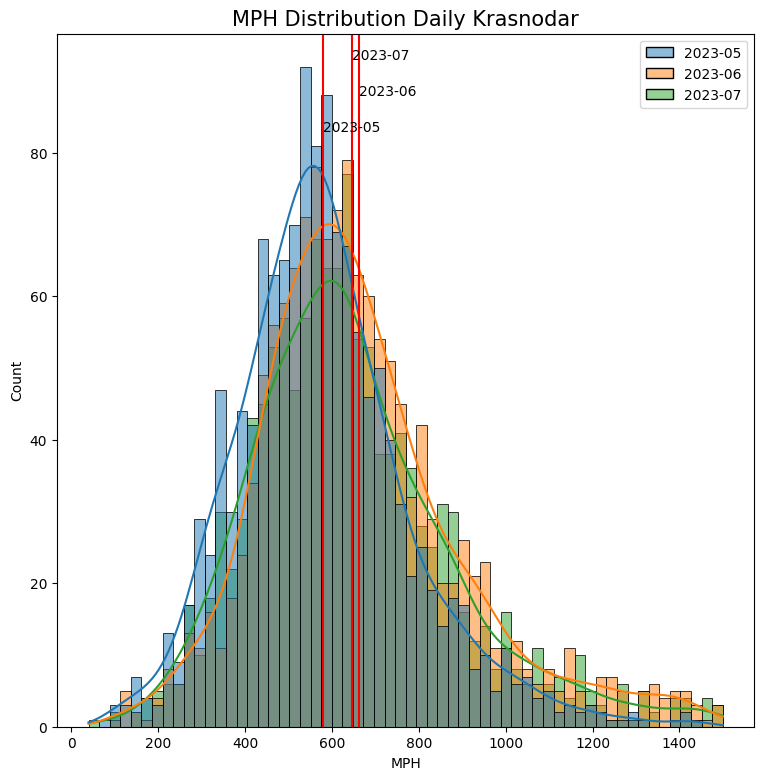

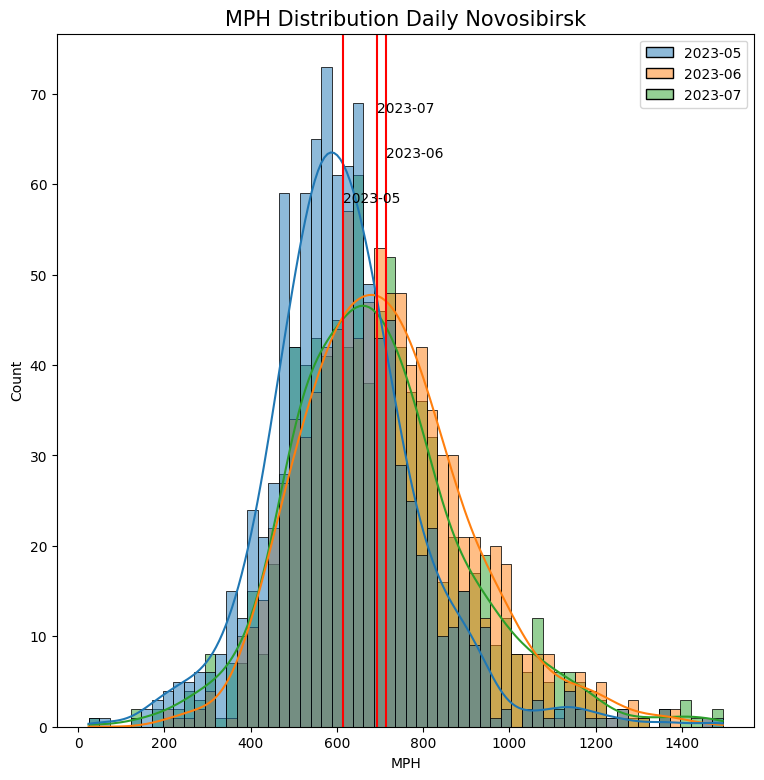

In [68]:
for node in regions['cities']:
    df_i = df_agg[df_agg['agglomeration']==node]
    mph_mean_i = df_i.mph.mean()
    df_i = df_i[df_i["mph"]<1500]

    data = {'2023-05':df_i[df_i['mnth']=='2023-05']['mph'].values,
            '2023-06':df_i[df_i['mnth']=='2023-06']['mph'].values,
            '2023-07':df_i[df_i['mnth']=='2023-07']['mph'].values}

    ax = sns.histplot(data, bins=60, kde=True)
    ax.set(xlabel="MPH")
    ax.set_title(f'MPH Distribution Daily {node}', fontsize=15)

    h = int(len(data[k])/15)
    for k in data.keys():
        ax.axvline(data[k].mean(), color = "red")
        ax.text(data[k].mean(),h,k)

        h+=5

    ax.figure.set_size_inches(9, 9)

    plt.show()